# Introduction to Enhanced Feature Exploration for Vaccine Response Prediction

Building on previous analyses using polynomial regression, this notebook explores the potential of incorporating additional features to improve the prediction of vaccine response. Despite efforts to optimize models using existing features, accuracy has not exceeded 75%. Therefore, this analysis focuses on leveraging new features, such as those related to immune cell responses post-vaccination, to enhance predictive capabilities.

## Objectives:
- **Feature Exploration**: Investigate the predictive power of features derived from `name_formatted` and `units`, which contain information about immune cell responses.
- **Model Evaluation**: Assess whether these new features improve model performance compared to previous iterations.
- **Performance Comparison**: Compare the accuracy and other metrics of models trained with these enhanced features against previous benchmarks.

---

## Step 1- Setup and Data Loading

First, we'll import the required libraries and load our preprocessed data.

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import mannwhitneyu

## Step 2- Data Loading

To begin the analysis, two datasets are loaded from CSV files:

- **Fluprint Filtered Data**: This dataset (`Fluprint.csv`) contains filtered data from the Fluprint database, which is used for initial explorations.
- **Aggregated Participants Data**: This dataset (`aggregated_participants.csv`) provides aggregated information about participants, offering a comprehensive view of the data. Note this might not be needed.

In [ ]:
path_to_fluprint_filtered = r"C:\Users\OneDrive\Documents\Applied Data science\FluPRINT_database\FluPRINT_filtered_data\Fluprint.csv"
path_to_fluprint = r"C:\Users\OneDrive\Documents\Applied Data science\FluPRINT_database\FluPRINT_filtered_data\aggregated_participants.csv"

fluprint_filtered_data = pd.read_csv(path_to_fluprint_filtered)
fluprint_data = pd.read_csv(path_to_fluprint)

## Step 3- Data Transformation: Pivoting and Column Renaming

To better organise the data for analysis, a pivot table is created from the `fluprint_filtered_data`. This transformation involves:

- **Pivoting**: The data is reshaped with `donor_id` as the index, and `name_formatted` and `units` as columns. The `aggfunc='first'` ensures that only the first value is kept for each combination.
- **Column Renaming**: The resulting column names are flattened to improve readability. This is necessary because the pivot operation creates tuple-like column names, which are then simplified into a single string format (e.g., `name_formatted_units`).

### Rationale for Using `name_formatted`
The `name_formatted` column is used as a primary identifier because it offers several advantages:
- **Standardised Naming**: It provides a consistent naming convention without special characters, making it easier to work with.
- **Clear Separation**: It clearly separates stimulation conditions and measured markers, enhancing the clarity and organization of the data.

In [3]:
# Pivot the data while keeping vaccine_response
pivoted_data_with_response = fluprint_filtered_data.pivot_table(
    values='data',
    index=['donor_id', 'vaccine_response'],  # Include vaccine_response in the index
    columns=['name_formatted', 'units'],
    aggfunc='first'
).reset_index()

# Flatten the column names
pivoted_data_with_response.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) and col[1] != '' else col[0] for col in pivoted_data_with_response.columns]

display(pivoted_data_with_response)

,donor_id,vaccine_response,BASO__as noted,BASO_CT_as noted,BDNF_Z.log2,B_cells_% of Parent,CD161_neg_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD45RA_neg_Tregs_% of Parent,CD161_pos_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD4_pos_T_cells_% of Parent,...,memory_B_cells_% of Parent,memory_B_cells_% of Viable,monocytes_% of Parent,naive_B_cells_% of Parent,naive_B_cells_% of Viable,naive_CD4_pos_T_cells_% of Parent,naive_CD8_pos_T_cells_% of Parent,pDCs_% of Parent,plasmablasts_% of Parent,transitional_B_cells_% of Parent
0,2,0.0,NaN,NaN,1.44,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0.0,NaN,NaN,-1.19,73.2,41.60,3.49,0.30,3.55,...,26.00,NaN,6.01,66.3,NaN,81.8,73.4,40.00,1.41,6.51
2,4,0.0,NaN,NaN,-0.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.0,NaN,NaN,1.22,57.7,45.90,3.64,0.11,5.55,...,19.20,NaN,11.90,73.6,NaN,80.8,61.8,28.80,1.52,5.85
4,6,0.0,NaN,NaN,0.45,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,809,0.0,NaN,NaN,0.10,40.8,3.42,3.82,0.20,13.70,...,6.09,NaN,27.00,93.0,NaN,32.0,34.8,4.92,0.14,0.14
357,810,0.0,NaN,NaN,-0.21,34.8,29.00,5.23,0.17,12.50,...,11.10,NaN,25.80,86.4,NaN,47.1,16.1,15.40,0.37,2.37
358,811,0.0,NaN,NaN,0.89,34.6,30.50,3.58,0.51,8.31,...,13.90,NaN,37.70,84.3,NaN,74.7,86.3,14.60,3.74,0.70
359,812,0.0,NaN,NaN,0.14,41.0,23.80,3.60,0.43,4.71,...,3.51,NaN,24.10,95.5,NaN,56.4,61.6,5.67,0.32,0.74


### Visualising Missing Data

A heatmap is used to visualize the distribution of missing values in the pivoted dataset. This helps identify columns with significant missing data and informs decisions on handling these gaps.


In [43]:
plt.figure(figsize=(200, 100))
sns.heatmap(pivoted_data_with_response.isnull(), cbar=True, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

### Identifying Duplicate Donor IDs and summary

To ensure data integrity, duplicate `donor_id`s are identified and extracted from the `pivoted_data`. This step helps in understanding if there are any repeated entries for the same donor.
The `info()` method is used to provide a concise summary of the `pivoted_data`, including information about the index data type, column data types, non-null values, and memory usage.


In [4]:
# Find duplicate donor_ids
duplicate_donors = pivoted_data_with_response[pivoted_data_with_response['donor_id'].duplicated()]

# Display duplicates
print(duplicate_donors)
pivoted_data_with_response.info()

Empty DataFrame
Columns: [donor_id, vaccine_response, BASO__as noted, BASO_CT_as noted, BDNF_Z.log2, B_cells_% of Parent, CD161_neg_CD45RA_pos_Tregs_% of Parent, CD161_pos_CD45RA_neg_Tregs_% of Parent, CD161_pos_CD45RA_pos_Tregs_% of Parent, CD161_pos_CD4_pos_T_cells_% of Parent, CD161_pos_CD4_pos_T_cells_% of Viable, CD161_pos_CD8_pos_T_cells_% of Parent, CD161_pos_NKT_cells_% of Parent, CD161_pos_NK_cells_% of Parent, CD161_pos_NK_cells_% of Viable, CD16_neg_CD56bright_NK_cells_% of Parent, CD16_pos_CD14_neg_monocytes_% of Parent, CD16_pos_CD14_pos_monocytes_% of Parent, CD16_pos_CD14_pos_monocytes_% of Viable, CD16_pos_monocytes_% of Parent, CD20_neg_CD3_neg_cells_% of Parent, CD27_pos_CD8_pos_T_cells_% of Parent, CD28_pos_CD4_pos_T_cells_% of Parent, CD28_pos_CD8_pos_T_cells_% of Parent, CD314_neg_CD94_neg_CD8_neg_T_cells_% of Parent, CD314_neg_CD94_neg_CD8_pos_T_cells_% of Parent, CD314_neg_CD94_neg_NK_cells_% of Parent, CD314_neg_CD94_pos_CD8_neg_T_cells_% of Parent, CD314_neg_CD

---

### Saving the Pivoted Data

To preserve the transformed dataset for future use or sharing, the `pivoted_data` is saved to a CSV file.


In [ ]:
# Define the directory path
path = r"C:\Users\OneDrive\Documents\Applied Data science\FluPRINT_database\FluPRINT_filtered_data"

# Construct the full file path
path_to_file = os.path.join(path, "pivoted_data.csv")

# Save the DataFrame to a CSV file
pivoted_data_with_response.to_csv(path_to_file, index=False)


### Counting Vaccine Response Classes

To understand the distribution of the `vaccine_response` variable, the counts of both classes (0 and 1) are calculated and printed. This will confirm if there is once again a class imbalance (like in our previous cases).

In [46]:
count_of_ones = (pivoted_data_with_response['vaccine_response'] == 1).sum()
print(f"Number of 1s in vaccine response: {count_of_ones}")

count_of_zeros = (pivoted_data_with_response['vaccine_response'] == 0).sum()
print(f"Number of 1s in vaccine response: {count_of_zeros}")

Number of 1s in vaccine response: 111
Number of 1s in vaccine response: 250


**Note** There does indeed seem to be a class imbalance towards low vaccine responders (0s).

---

## Step 4-  Removing Columns with High NaN Values

To handle missing data, columns with a high percentage of NaN values are removed. This process is repeated for various thresholds (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9) to explore the impact on dataset size and quality.

In [47]:
nan_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for nan_threshold in nan_thresholds:
    columns_to_keep = pivoted_data_with_response.columns[pivoted_data_with_response.isnull().mean() < nan_threshold]
    final_data_cleaned = pivoted_data_with_response[columns_to_keep]
    
    print(f"Threshold: {nan_threshold}")
    print(f"Original shape: {pivoted_data_with_response.shape}")
    print(f"Shape after removing high-NaN columns: {final_data_cleaned.shape}")
    display(final_data_cleaned)

Threshold: 0.2
Original shape: (361, 3345)
Shape after removing high-NaN columns: (361, 42)


,donor_id,vaccine_response,B_cells_% of Parent,CD161_neg_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD45RA_neg_Tregs_% of Parent,CD161_pos_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD4_pos_T_cells_% of Parent,CD161_pos_CD8_pos_T_cells_% of Parent,CD28_pos_CD8_pos_T_cells_% of Parent,CD4_pos_T_cells_% of Parent,...,effector_memory_CD4_pos_T_cells_% of Parent,effector_memory_CD8_pos_T_cells_% of Parent,gamma_neg_delta_T_cells_% of Parent,memory_B_cells_% of Parent,monocytes_% of Parent,naive_B_cells_% of Parent,naive_CD4_pos_T_cells_% of Parent,naive_CD8_pos_T_cells_% of Parent,plasmablasts_% of Parent,transitional_B_cells_% of Parent
0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0.0,73.2,41.60,3.49,0.30,3.55,9.07,88.6,58.3,...,3.27,9.60,2.78,26.00,6.01,66.3,81.8,73.4,1.41,6.51
2,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.0,57.7,45.90,3.64,0.11,5.55,8.90,82.2,54.9,...,4.42,14.70,3.16,19.20,11.90,73.6,80.8,61.8,1.52,5.85
4,6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,809,0.0,40.8,3.42,3.82,0.20,13.70,4.66,59.0,49.1,...,31.00,42.10,2.53,6.09,27.00,93.0,32.0,34.8,0.14,0.14
357,810,0.0,34.8,29.00,5.23,0.17,12.50,36.60,35.6,45.4,...,12.00,19.90,2.63,11.10,25.80,86.4,47.1,16.1,0.37,2.37
358,811,0.0,34.6,30.50,3.58,0.51,8.31,3.84,95.8,63.1,...,4.21,5.31,1.05,13.90,37.70,84.3,74.7,86.3,3.74,0.70
359,812,0.0,41.0,23.80,3.60,0.43,4.71,3.09,86.7,70.7,...,12.70,17.10,1.27,3.51,24.10,95.5,56.4,61.6,0.32,0.74


Threshold: 0.3
Original shape: (361, 3345)
Shape after removing high-NaN columns: (361, 50)


,donor_id,vaccine_response,B_cells_% of Parent,CD161_neg_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD45RA_neg_Tregs_% of Parent,CD161_pos_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD4_pos_T_cells_% of Parent,CD161_pos_CD8_pos_T_cells_% of Parent,CD161_pos_NK_cells_% of Parent,CD16_pos_monocytes_% of Parent,...,effector_memory_CD4_pos_T_cells_% of Parent,effector_memory_CD8_pos_T_cells_% of Parent,gamma_neg_delta_T_cells_% of Parent,memory_B_cells_% of Parent,monocytes_% of Parent,naive_B_cells_% of Parent,naive_CD4_pos_T_cells_% of Parent,naive_CD8_pos_T_cells_% of Parent,plasmablasts_% of Parent,transitional_B_cells_% of Parent
0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0.0,73.2,41.60,3.49,0.30,3.55,9.07,40.7,3.89,...,3.27,9.60,2.78,26.00,6.01,66.3,81.8,73.4,1.41,6.51
2,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.0,57.7,45.90,3.64,0.11,5.55,8.90,71.7,3.10,...,4.42,14.70,3.16,19.20,11.90,73.6,80.8,61.8,1.52,5.85
4,6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,809,0.0,40.8,3.42,3.82,0.20,13.70,4.66,69.0,3.45,...,31.00,42.10,2.53,6.09,27.00,93.0,32.0,34.8,0.14,0.14
357,810,0.0,34.8,29.00,5.23,0.17,12.50,36.60,49.9,1.64,...,12.00,19.90,2.63,11.10,25.80,86.4,47.1,16.1,0.37,2.37
358,811,0.0,34.6,30.50,3.58,0.51,8.31,3.84,80.8,4.10,...,4.21,5.31,1.05,13.90,37.70,84.3,74.7,86.3,3.74,0.70
359,812,0.0,41.0,23.80,3.60,0.43,4.71,3.09,48.3,7.78,...,12.70,17.10,1.27,3.51,24.10,95.5,56.4,61.6,0.32,0.74


Threshold: 0.4
Original shape: (361, 3345)
Shape after removing high-NaN columns: (361, 101)


,donor_id,vaccine_response,B_cells_% of Parent,CD161_neg_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD45RA_neg_Tregs_% of Parent,CD161_pos_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD4_pos_T_cells_% of Parent,CD161_pos_CD8_pos_T_cells_% of Parent,CD161_pos_NK_cells_% of Parent,CD16_pos_monocytes_% of Parent,...,effector_memory_CD4_pos_T_cells_% of Parent,effector_memory_CD8_pos_T_cells_% of Parent,gamma_neg_delta_T_cells_% of Parent,memory_B_cells_% of Parent,monocytes_% of Parent,naive_B_cells_% of Parent,naive_CD4_pos_T_cells_% of Parent,naive_CD8_pos_T_cells_% of Parent,plasmablasts_% of Parent,transitional_B_cells_% of Parent
0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0.0,73.2,41.60,3.49,0.30,3.55,9.07,40.7,3.89,...,3.27,9.60,2.78,26.00,6.01,66.3,81.8,73.4,1.41,6.51
2,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.0,57.7,45.90,3.64,0.11,5.55,8.90,71.7,3.10,...,4.42,14.70,3.16,19.20,11.90,73.6,80.8,61.8,1.52,5.85
4,6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,809,0.0,40.8,3.42,3.82,0.20,13.70,4.66,69.0,3.45,...,31.00,42.10,2.53,6.09,27.00,93.0,32.0,34.8,0.14,0.14
357,810,0.0,34.8,29.00,5.23,0.17,12.50,36.60,49.9,1.64,...,12.00,19.90,2.63,11.10,25.80,86.4,47.1,16.1,0.37,2.37
358,811,0.0,34.6,30.50,3.58,0.51,8.31,3.84,80.8,4.10,...,4.21,5.31,1.05,13.90,37.70,84.3,74.7,86.3,3.74,0.70
359,812,0.0,41.0,23.80,3.60,0.43,4.71,3.09,48.3,7.78,...,12.70,17.10,1.27,3.51,24.10,95.5,56.4,61.6,0.32,0.74


Threshold: 0.5
Original shape: (361, 3345)
Shape after removing high-NaN columns: (361, 103)


,donor_id,vaccine_response,B_cells_% of Parent,CD161_neg_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD45RA_neg_Tregs_% of Parent,CD161_pos_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD4_pos_T_cells_% of Parent,CD161_pos_CD8_pos_T_cells_% of Parent,CD161_pos_NK_cells_% of Parent,CD16_pos_monocytes_% of Parent,...,effector_memory_CD4_pos_T_cells_% of Parent,effector_memory_CD8_pos_T_cells_% of Parent,gamma_neg_delta_T_cells_% of Parent,memory_B_cells_% of Parent,monocytes_% of Parent,naive_B_cells_% of Parent,naive_CD4_pos_T_cells_% of Parent,naive_CD8_pos_T_cells_% of Parent,plasmablasts_% of Parent,transitional_B_cells_% of Parent
0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0.0,73.2,41.60,3.49,0.30,3.55,9.07,40.7,3.89,...,3.27,9.60,2.78,26.00,6.01,66.3,81.8,73.4,1.41,6.51
2,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.0,57.7,45.90,3.64,0.11,5.55,8.90,71.7,3.10,...,4.42,14.70,3.16,19.20,11.90,73.6,80.8,61.8,1.52,5.85
4,6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,809,0.0,40.8,3.42,3.82,0.20,13.70,4.66,69.0,3.45,...,31.00,42.10,2.53,6.09,27.00,93.0,32.0,34.8,0.14,0.14
357,810,0.0,34.8,29.00,5.23,0.17,12.50,36.60,49.9,1.64,...,12.00,19.90,2.63,11.10,25.80,86.4,47.1,16.1,0.37,2.37
358,811,0.0,34.6,30.50,3.58,0.51,8.31,3.84,80.8,4.10,...,4.21,5.31,1.05,13.90,37.70,84.3,74.7,86.3,3.74,0.70
359,812,0.0,41.0,23.80,3.60,0.43,4.71,3.09,48.3,7.78,...,12.70,17.10,1.27,3.51,24.10,95.5,56.4,61.6,0.32,0.74


Threshold: 0.6
Original shape: (361, 3345)
Shape after removing high-NaN columns: (361, 129)


,donor_id,vaccine_response,B_cells_% of Parent,CD161_neg_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD45RA_neg_Tregs_% of Parent,CD161_pos_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD4_pos_T_cells_% of Parent,CD161_pos_CD8_pos_T_cells_% of Parent,CD161_pos_NKT_cells_% of Parent,CD161_pos_NK_cells_% of Parent,...,gamma_neg_delta_T_cells_% of Parent,mDCs_% of Parent,memory_B_cells_% of Parent,monocytes_% of Parent,naive_B_cells_% of Parent,naive_CD4_pos_T_cells_% of Parent,naive_CD8_pos_T_cells_% of Parent,pDCs_% of Parent,plasmablasts_% of Parent,transitional_B_cells_% of Parent
0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0.0,73.2,41.60,3.49,0.30,3.55,9.07,83.9,40.7,...,2.78,11.20,26.00,6.01,66.3,81.8,73.4,40.00,1.41,6.51
2,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.0,57.7,45.90,3.64,0.11,5.55,8.90,74.8,71.7,...,3.16,11.00,19.20,11.90,73.6,80.8,61.8,28.80,1.52,5.85
4,6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,809,0.0,40.8,3.42,3.82,0.20,13.70,4.66,24.4,69.0,...,2.53,4.46,6.09,27.00,93.0,32.0,34.8,4.92,0.14,0.14
357,810,0.0,34.8,29.00,5.23,0.17,12.50,36.60,64.6,49.9,...,2.63,25.70,11.10,25.80,86.4,47.1,16.1,15.40,0.37,2.37
358,811,0.0,34.6,30.50,3.58,0.51,8.31,3.84,61.5,80.8,...,1.05,10.10,13.90,37.70,84.3,74.7,86.3,14.60,3.74,0.70
359,812,0.0,41.0,23.80,3.60,0.43,4.71,3.09,41.5,48.3,...,1.27,6.67,3.51,24.10,95.5,56.4,61.6,5.67,0.32,0.74


Threshold: 0.7
Original shape: (361, 3345)
Shape after removing high-NaN columns: (361, 273)


,donor_id,vaccine_response,B_cells_% of Parent,CD161_neg_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD45RA_neg_Tregs_% of Parent,CD161_pos_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD4_pos_T_cells_% of Parent,CD161_pos_CD8_pos_T_cells_% of Parent,CD161_pos_NKT_cells_% of Parent,CD161_pos_NK_cells_% of Parent,...,gamma_neg_delta_T_cells_% of Parent,mDCs_% of Parent,memory_B_cells_% of Parent,monocytes_% of Parent,naive_B_cells_% of Parent,naive_CD4_pos_T_cells_% of Parent,naive_CD8_pos_T_cells_% of Parent,pDCs_% of Parent,plasmablasts_% of Parent,transitional_B_cells_% of Parent
0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0.0,73.2,41.60,3.49,0.30,3.55,9.07,83.9,40.7,...,2.78,11.20,26.00,6.01,66.3,81.8,73.4,40.00,1.41,6.51
2,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.0,57.7,45.90,3.64,0.11,5.55,8.90,74.8,71.7,...,3.16,11.00,19.20,11.90,73.6,80.8,61.8,28.80,1.52,5.85
4,6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,809,0.0,40.8,3.42,3.82,0.20,13.70,4.66,24.4,69.0,...,2.53,4.46,6.09,27.00,93.0,32.0,34.8,4.92,0.14,0.14
357,810,0.0,34.8,29.00,5.23,0.17,12.50,36.60,64.6,49.9,...,2.63,25.70,11.10,25.80,86.4,47.1,16.1,15.40,0.37,2.37
358,811,0.0,34.6,30.50,3.58,0.51,8.31,3.84,61.5,80.8,...,1.05,10.10,13.90,37.70,84.3,74.7,86.3,14.60,3.74,0.70
359,812,0.0,41.0,23.80,3.60,0.43,4.71,3.09,41.5,48.3,...,1.27,6.67,3.51,24.10,95.5,56.4,61.6,5.67,0.32,0.74


Threshold: 0.8
Original shape: (361, 3345)
Shape after removing high-NaN columns: (361, 385)


,donor_id,vaccine_response,BDNF_Z.log2,B_cells_% of Parent,CD161_neg_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD45RA_neg_Tregs_% of Parent,CD161_pos_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD4_pos_T_cells_% of Parent,CD161_pos_CD8_pos_T_cells_% of Parent,CD161_pos_NKT_cells_% of Parent,...,gamma_neg_delta_T_cells_% of Parent,mDCs_% of Parent,memory_B_cells_% of Parent,monocytes_% of Parent,naive_B_cells_% of Parent,naive_CD4_pos_T_cells_% of Parent,naive_CD8_pos_T_cells_% of Parent,pDCs_% of Parent,plasmablasts_% of Parent,transitional_B_cells_% of Parent
0,2,0.0,1.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0.0,-1.19,73.2,41.60,3.49,0.30,3.55,9.07,83.9,...,2.78,11.20,26.00,6.01,66.3,81.8,73.4,40.00,1.41,6.51
2,4,0.0,-0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.0,1.22,57.7,45.90,3.64,0.11,5.55,8.90,74.8,...,3.16,11.00,19.20,11.90,73.6,80.8,61.8,28.80,1.52,5.85
4,6,0.0,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,809,0.0,0.10,40.8,3.42,3.82,0.20,13.70,4.66,24.4,...,2.53,4.46,6.09,27.00,93.0,32.0,34.8,4.92,0.14,0.14
357,810,0.0,-0.21,34.8,29.00,5.23,0.17,12.50,36.60,64.6,...,2.63,25.70,11.10,25.80,86.4,47.1,16.1,15.40,0.37,2.37
358,811,0.0,0.89,34.6,30.50,3.58,0.51,8.31,3.84,61.5,...,1.05,10.10,13.90,37.70,84.3,74.7,86.3,14.60,3.74,0.70
359,812,0.0,0.14,41.0,23.80,3.60,0.43,4.71,3.09,41.5,...,1.27,6.67,3.51,24.10,95.5,56.4,61.6,5.67,0.32,0.74


Threshold: 0.9
Original shape: (361, 3345)
Shape after removing high-NaN columns: (361, 413)


,donor_id,vaccine_response,BDNF_Z.log2,B_cells_% of Parent,CD161_neg_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD45RA_neg_Tregs_% of Parent,CD161_pos_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD4_pos_T_cells_% of Parent,CD161_pos_CD8_pos_T_cells_% of Parent,CD161_pos_NKT_cells_% of Parent,...,gamma_neg_delta_T_cells_% of Parent,mDCs_% of Parent,memory_B_cells_% of Parent,monocytes_% of Parent,naive_B_cells_% of Parent,naive_CD4_pos_T_cells_% of Parent,naive_CD8_pos_T_cells_% of Parent,pDCs_% of Parent,plasmablasts_% of Parent,transitional_B_cells_% of Parent
0,2,0.0,1.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0.0,-1.19,73.2,41.60,3.49,0.30,3.55,9.07,83.9,...,2.78,11.20,26.00,6.01,66.3,81.8,73.4,40.00,1.41,6.51
2,4,0.0,-0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.0,1.22,57.7,45.90,3.64,0.11,5.55,8.90,74.8,...,3.16,11.00,19.20,11.90,73.6,80.8,61.8,28.80,1.52,5.85
4,6,0.0,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,809,0.0,0.10,40.8,3.42,3.82,0.20,13.70,4.66,24.4,...,2.53,4.46,6.09,27.00,93.0,32.0,34.8,4.92,0.14,0.14
357,810,0.0,-0.21,34.8,29.00,5.23,0.17,12.50,36.60,64.6,...,2.63,25.70,11.10,25.80,86.4,47.1,16.1,15.40,0.37,2.37
358,811,0.0,0.89,34.6,30.50,3.58,0.51,8.31,3.84,61.5,...,1.05,10.10,13.90,37.70,84.3,74.7,86.3,14.60,3.74,0.70
359,812,0.0,0.14,41.0,23.80,3.60,0.43,4.71,3.09,41.5,...,1.27,6.67,3.51,24.10,95.5,56.4,61.6,5.67,0.32,0.74


### The impact of different thresholds on feature retention is summarized below:

| Threshold | Columns Remaining | Reduction (%) |
|-----------|-------------------|---------------|
| 90%       | 413               | ~88%          |
| 80%       | 385               | ~88%          |
| 70%       | 273               | ~92%          |
| 60%       | 129               | ~96%          |
| 50%       | 103               | ~97%          |

### Rationale for Choosing the 70% Threshold
A threshold of 70% was chosen because it strikes a balance between preserving biologically relevant features and maintaining data quality. This threshold retains immune cell subsets and signaling markers crucial for understanding vaccine response (e.g., IFN-α/γ pathways) while excluding features with excessive sparsity that could introduce noise.

- **Stricter Thresholds**: Applying a stricter threshold (e.g., 60%) would discard more than 96% of features, potentially losing subtle but important signals.
- **Lenient Thresholds**: Conversely, using a lenient threshold (e.g., 90%) would retain highly sparse features with limited analytical utility.


In [6]:
nan_threshold = 0.7
columns_to_keep = pivoted_data_with_response.columns[pivoted_data_with_response.isnull().mean() < nan_threshold]
pivoted_data_cleaned_70 = pivoted_data_with_response[columns_to_keep]

print("Original shape:", pivoted_data_with_response.shape)
print("Shape after removing high-NaN columns:", pivoted_data_cleaned_70.shape)

Original shape: (361, 3345)
Shape after removing high-NaN columns: (361, 273)


## Step 5 - Imputation of Missing Values

### Rationale for Imputation
After applying the 70% threshold to retain relevant features, some features still contain missing values. To ensure that the dataset is complete and suitable for downstream analysis, we apply **median imputation** to fill in missing values.

### Next Steps
- **Normalisation/Scaling**: After imputation, features may need to be normalised or scaled (e.g., using `StandardScaler`) to ensure compatibility with models like logistic regression or SVMs.
- **Model Training and Validation**: The imputed dataset will be used for training machine learning models, ensuring that no information is lost due to missing values.

In [7]:
# Split data into features and target
features = pivoted_data_cleaned_70.drop(columns=['donor_id', 'vaccine_response'])
target = pivoted_data_cleaned_70['vaccine_response']

# Split into train/test sets FIRST to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Define a pipeline: Impute → Scale
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Median imputation for robustness
    ('scaler', MinMaxScaler())  # Use StandardScaler() if preferred
])

# Fit on training data and transform both train/test
X_train_normalized = pipeline.fit_transform(X_train)
X_test_normalized = pipeline.transform(X_test)

# Rebuild DataFrames with normalized features and target
train_data_normalized = pd.DataFrame(
    X_train_normalized, 
    columns=features.columns
).assign(vaccine_response=y_train.reset_index(drop=True))

test_data_normalized = pd.DataFrame(
    X_test_normalized, 
    columns=features.columns
).assign(vaccine_response=y_test.reset_index(drop=True))

display(train_data_normalized)

,B_cells_% of Parent,CD161_neg_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD45RA_neg_Tregs_% of Parent,CD161_pos_CD45RA_pos_Tregs_% of Parent,CD161_pos_CD4_pos_T_cells_% of Parent,CD161_pos_CD8_pos_T_cells_% of Parent,CD161_pos_NKT_cells_% of Parent,CD161_pos_NK_cells_% of Parent,CD16_neg_CD56bright_NK_cells_% of Parent,CD16_pos_CD14_neg_monocytes_% of Parent,...,mDCs_% of Parent,memory_B_cells_% of Parent,monocytes_% of Parent,naive_B_cells_% of Parent,naive_CD4_pos_T_cells_% of Parent,naive_CD8_pos_T_cells_% of Parent,pDCs_% of Parent,plasmablasts_% of Parent,transitional_B_cells_% of Parent,vaccine_response
0,0.569243,0.231442,0.154717,0.068807,0.134065,0.106436,0.468852,0.639445,0.243339,0.046448,...,0.308561,0.419199,0.162981,0.593516,0.538056,0.693783,0.182493,0.025738,0.058007,1.0
1,0.472804,0.246748,0.300943,0.100917,0.290866,0.205628,0.468852,0.645701,0.243339,0.046448,...,0.308561,0.330465,0.224226,0.628429,0.530876,0.581696,0.182493,0.039662,0.161765,0.0
2,0.818696,0.001640,0.618868,0.073394,0.288514,0.190304,0.735007,0.724750,0.360568,0.315301,...,0.004390,0.134176,0.663151,0.860349,0.554811,0.544719,0.605836,0.019831,0.089869,0.0
3,0.467661,0.240188,0.626415,0.380734,0.345355,0.334076,0.655974,0.600773,0.198934,0.102732,...,0.361869,0.938155,0.188499,0.119701,0.615845,0.729605,0.091119,0.014768,0.066176,0.0
4,0.738974,0.185525,0.525472,0.293578,0.462956,0.414879,0.744305,0.539354,0.158082,0.010383,...,0.433992,0.911266,0.124532,0.139651,0.332216,0.622140,0.061172,0.035443,0.103758,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.313360,0.196458,0.684906,0.293578,0.372795,0.350794,0.393305,0.649682,0.303730,0.014208,...,0.308561,0.405754,0.396053,0.623441,0.573959,0.446499,0.165344,0.051899,0.077614,0.0
284,0.297930,0.307970,0.360377,0.422018,0.230498,0.151853,0.246862,0.284577,0.341030,0.011475,...,0.361869,0.362732,0.324600,0.665835,0.479416,0.454587,0.045303,0.017300,0.080065,0.0
285,0.472804,0.246748,0.300943,0.100917,0.290866,0.205628,0.468852,0.645701,0.243339,0.046448,...,0.308561,0.330465,0.224226,0.628429,0.530876,0.581696,0.182493,0.039662,0.161765,0.0
286,0.472804,0.246748,0.300943,0.100917,0.290866,0.205628,0.468852,0.645701,0.243339,0.046448,...,0.308561,0.330465,0.224226,0.628429,0.530876,0.581696,0.182493,0.039662,0.161765,0.0


In [ ]:
# Define the directory path
path = r"C:\Users\OneDrive\Documents\Applied Data science\FluPRINT_database\FluPRINT_filtered_data"

# Construct the full file path
path_to_file = os.path.join(path, "pivoted_data_stand.csv")

# Save the DataFrame to a CSV file
train_data_normalized.to_csv(path_to_file, index=False)

### Exploratory Analysis: Feature Differences Between High and Low Responders

In [50]:
high_responders = final_data_imputed[final_data_imputed['vaccine_response'] == 1]
low_responders = final_data_imputed[final_data_imputed['vaccine_response'] == 0]

# Compute mean differences between high and low responders
mean_high = high_responders.drop(columns=['vaccine_response']).mean()
mean_low = low_responders.drop(columns=['vaccine_response']).mean()
diff_mean = mean_high - mean_low

# Sort by largest absolute differences
diff_mean_sorted = diff_mean.abs().sort_values(ascending=False)

print("Top 10 Features Differentiating High and Low Responders:")
display(diff_mean_sorted.head(10))


Top 10 Features Differentiating High and Low Responders:


IFNa_CD8_pos_CD45RA_pos_pSTAT1_90th %tile         186.885477
IL_neg_6_CD4_pos_CD45RA_pos_pSTAT1_90th %tile     152.188901
IFNa_CD4_pos_CD45RA_neg_pSTAT1_90th %tile         141.570919
IL_neg_6_CD4_pos_pSTAT1_90th %tile                132.198090
IFNg_Mono_pSTAT1_90th %tile                       128.803748
IFNa_CD8_pos_pSTAT1_90th %tile                    127.456288
IL_neg_6_CD8_pos_CD45RA_pos_pSTAT1_90th %tile     124.684829
IFNa_CD4_pos_CD45RA_pos_pSTAT1_90th %tile         115.719676
IL_neg_6_CD4_pos_CD45RA_neg_pSTAT1_90th %tile      93.458234
IL_neg_10_CD4_pos_CD45RA_neg_pSTAT1_90th %tile     92.100396
dtype: float64

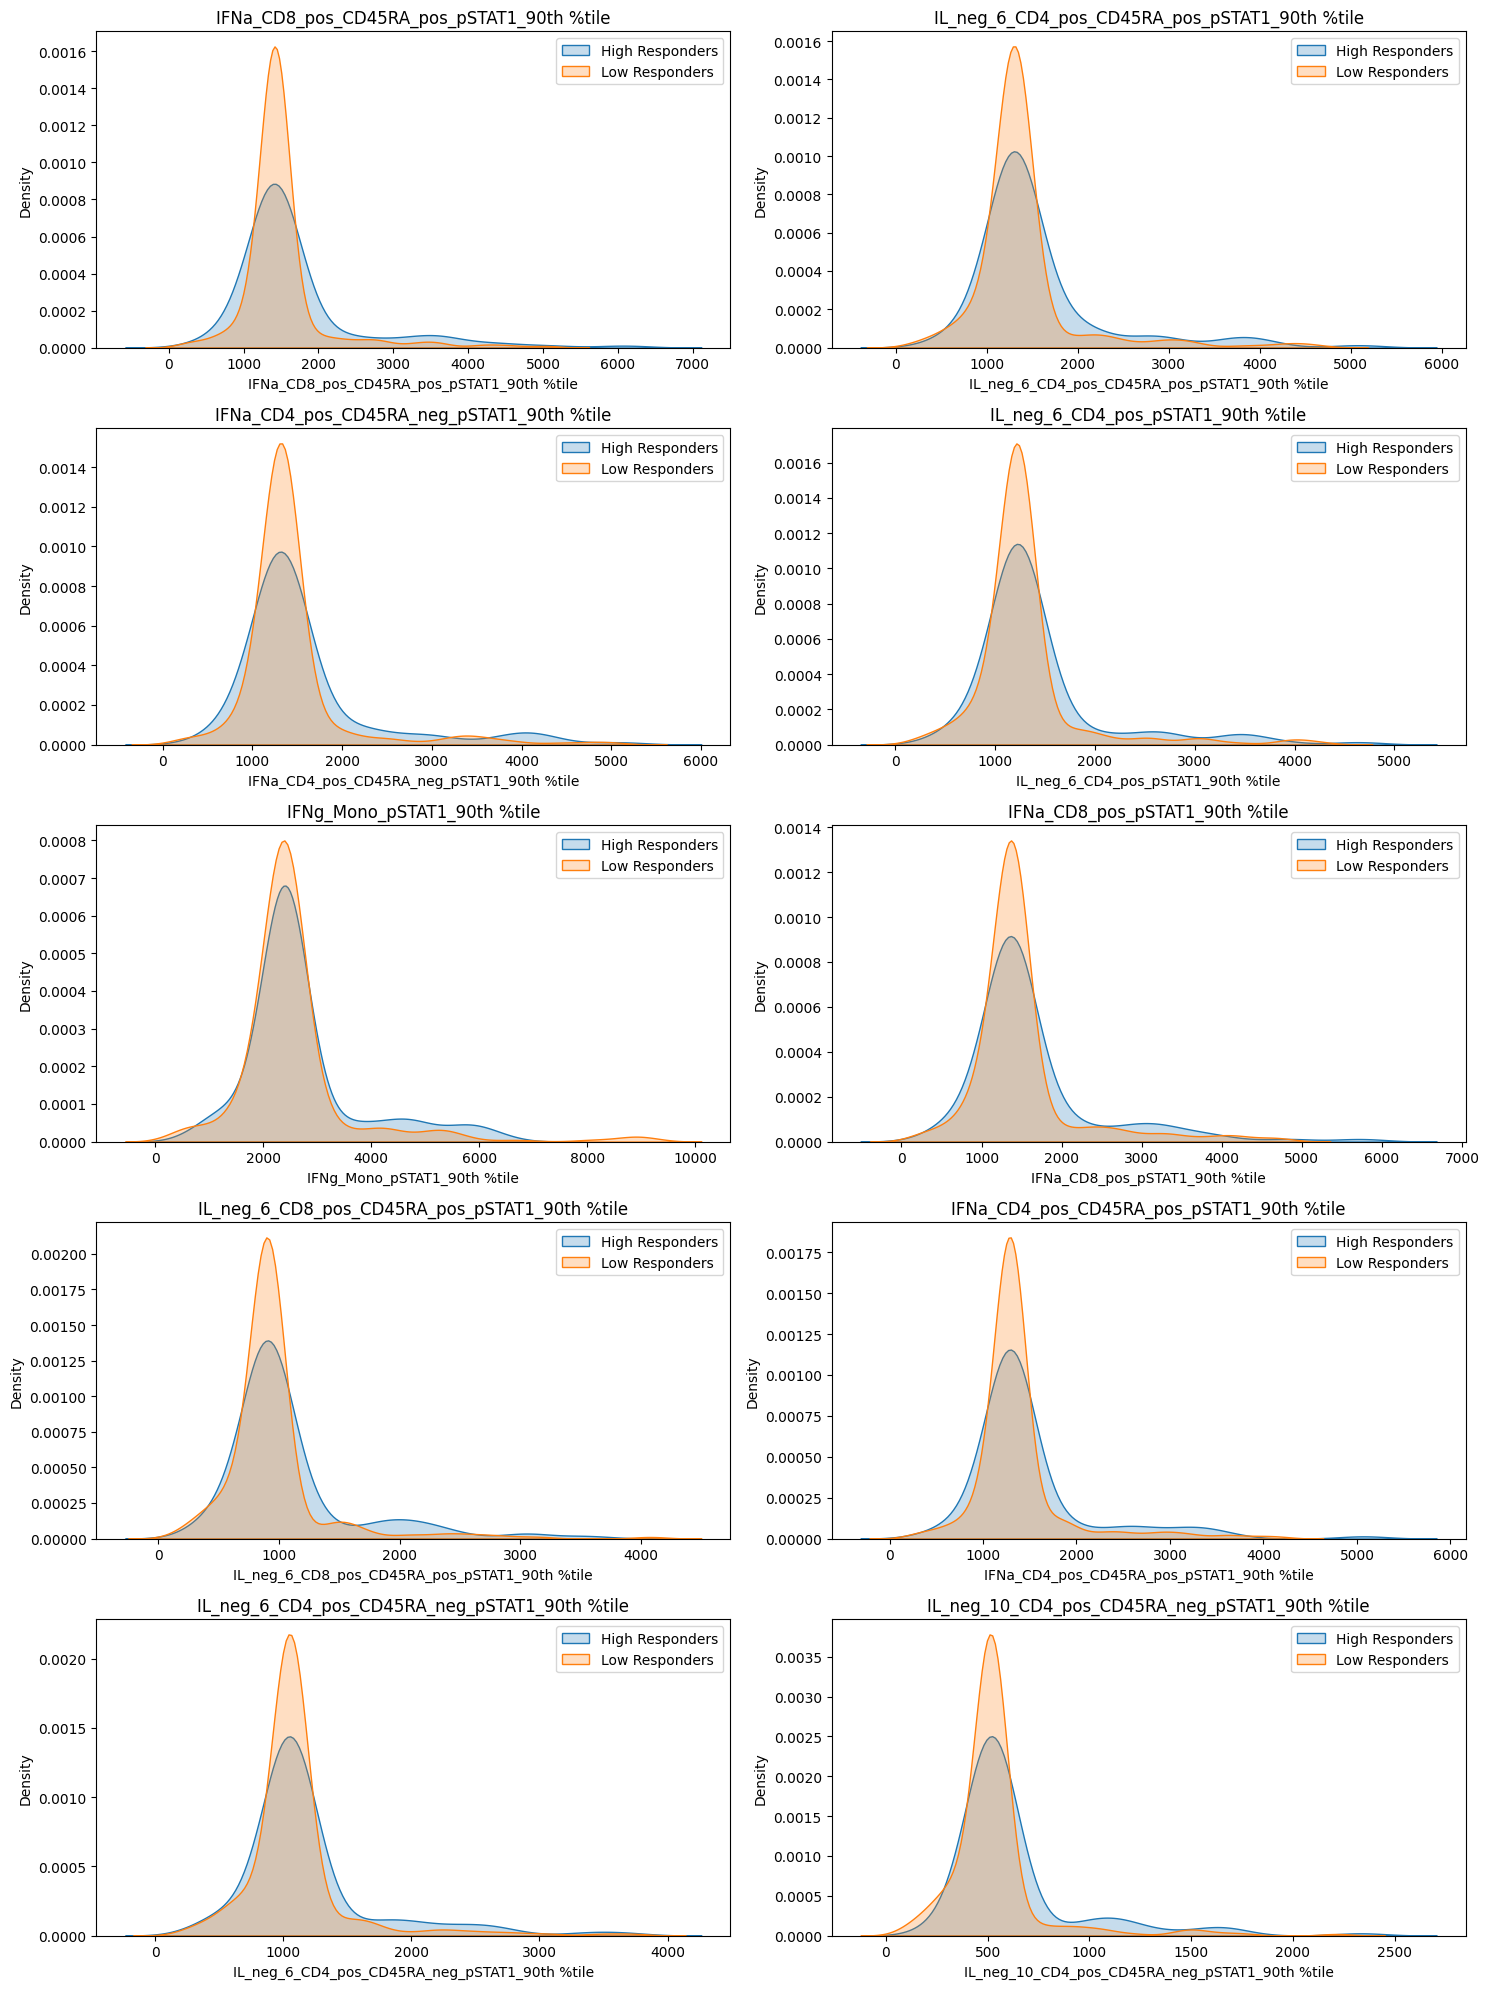

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top features
top_features = diff_mean_sorted.head(10).index

# Create a FacetGrid for all features
fig, axes = plt.subplots(5, 2, figsize=(15, 20))  # 5 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, feature in enumerate(top_features):
    sns.kdeplot(high_responders[feature], label='High Responders', fill=True, ax=axes[i])
    sns.kdeplot(low_responders[feature], label='Low Responders', fill=True, ax=axes[i])
    axes[i].set_title(f"{feature}")
    axes[i].legend()

plt.tight_layout()
plt.show()

### Visualisation: Top 5 Features Differentiating High and Low Responders

#### Purpose of the Graph:
This graph uses **strip plots** to visualize the distribution of values for the top 5 features that show the largest mean differences between high and low responders. The goal is to confirm whether these features truly differentiate between the two groups or if their distributions overlap significantly.

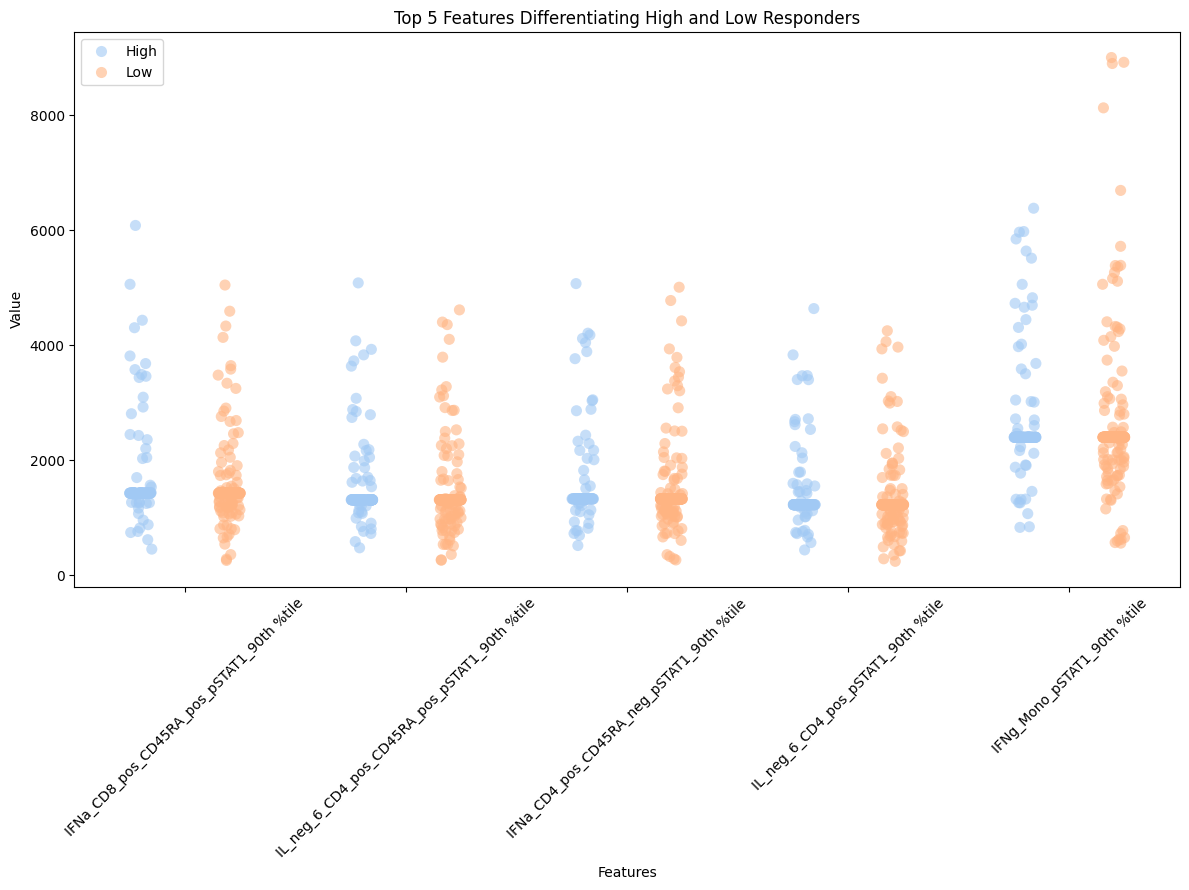

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top 5 features with largest differences
top_features = diff_mean_sorted.head(5).index.tolist()

# Combine high and low responder data for plotting
combined = pd.concat([
    high_responders[top_features].assign(Group='High'),
    low_responders[top_features].assign(Group='Low')
])

# Melt for boxplot formatting
combined_melted = combined.melt(id_vars='Group', var_name='Feature', value_name='Value')

# Plot boxplots with larger points using stripplot
plt.figure(figsize=(12, 9))
sns.stripplot(data=combined_melted, x='Feature', y='Value', hue='Group',
              dodge=True, palette='pastel', alpha=0.6, size=8)


# Customize plot appearance
plt.title('Top 5 Features Differentiating High and Low Responders')
plt.xlabel('Features')  
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Statistical Testing: Mann-Whitney U Test for Top Features

#### Purpose of the Test:
The **Mann-Whitney U test** is used to determine whether there is a statistically significant difference in the distributions of each feature between high and low responders. This test is particularly useful because:
- It does not assume normality in the data.
- It compares the ranks of values rather than their actual values, making it robust to outliers.

In [53]:
results = []
for feature in top_features:
    stat, p = mannwhitneyu(
        high_responders[feature],
        low_responders[feature],
        alternative='two-sided'
    )
    results.append({'Feature': feature, 'p-value': p})

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='p-value'))

                                         Feature   p-value
3             IL_neg_6_CD4_pos_pSTAT1_90th %tile  0.041659
1  IL_neg_6_CD4_pos_CD45RA_pos_pSTAT1_90th %tile  0.043321
4                    IFNg_Mono_pSTAT1_90th %tile  0.101049
0      IFNa_CD8_pos_CD45RA_pos_pSTAT1_90th %tile  0.128313
2      IFNa_CD4_pos_CD45RA_neg_pSTAT1_90th %tile  0.142544


### Key Observations:

1. **Significant Features**:
   - **IL_neg_6_CD4_pos_pSTAT1_90th %tile** (p = 0.0417) and **IL_neg_6_CD4_pos_CD45RA_pos_pSTAT1_90th %tile** (p = 0.0433) have p-values below the commonly used threshold of **0.05**, indicating that these features show statistically significant differences between high and low responders.

2. **Marginally Significant Features**:
   - **IFNg_Mono_pSTAT1_90th %tile** (p = 0.101) and **IFNa_CD8_pos_CD45RA_pos_pSTAT1_90th %tile** (p = 0.128) have p-values above 0.05 but below 0.15.

3. **Non-Significant Feature**:
   - **IFNa_CD4_pos_CD45RA_neg_pSTAT1_90th %tile** (p = 0.143) does not show a statistically significant difference between high and low responders.
   - This feature likely does not contribute strongly to distinguishing between the two groups.

---

### Biological Interpretation:

#### Significant Features:
1. **IL_neg_6_CD4_pos_pSTAT1_90th %tile**:
   - This feature measures STAT1 phosphorylation in CD4+ T cells under Interleukin-6 negative control conditions.
   - A significant difference suggests that CD4+ T cell signaling in response to IL-6 may play a role in vaccine response.

2. **IL_neg_6_CD4_pos_CD45RA_pos_pSTAT1_90th %tile**:
   - This feature focuses on naive CD4+ T cells (`CD45RA+`) under similar conditions.
   - The significance here highlights the potential importance of naive T cell populations in vaccine efficacy.

#### Marginally Significant Features:
- **IFNg_Mono_pSTAT1_90th %tile**:
   - Measures STAT1 phosphorylation in monocytes under Interferon-gamma stimulation.
   - Although not statistically significant, this feature may indicate a trend where monocyte signaling contributes to vaccine response.

---

### Limitations:
- **Multiple Testing**: Since multiple features were tested, there is a risk of false positives due to multiple comparisons.
  - Apply a correction method like Benjamini-Hochberg to control for false discovery rate (FDR).
- **Sample Size**: If the sample size is small, it may reduce the power of the test to detect true differences.